Import libraries

In [1]:
%pip install ta

In [2]:
import pandas as pd
import math
import yfinance as yf
import numpy as np
import datetime
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('fivethirtyeight')
import pandas_datareader.data as web
import ta

In [3]:
# print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


# Stock Market Data

## Exploratory Data Analysis - Analyse data from 2012 - 2025

Download Northern Oil & Gas data from 2012 - 2025 in a dataframe using YahooFinance API

In [3]:
starttime = datetime.datetime(2012, 1, 1)
endtime = datetime.datetime(2025, 4, 27)
ticker = "NOG"
df = yf.download(ticker, start=starttime, end=endtime)
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NOG,NOG,NOG,NOG,NOG
Date,,,,,
2012-01-03,216.132462,220.474215,212.745899,212.919567,201990
2012-01-04,223.339813,224.121324,214.048450,218.737539,77410
2012-01-05,218.650711,220.995255,210.748714,218.911219,128430
2012-01-06,210.314545,221.342596,210.314545,221.342596,92800
2012-01-09,212.919601,218.563881,208.838356,212.572266,75170


In [3]:
df = pd.read_csv(r'/content/NOG_2012-01-01_2025-04-27.csv')
df.head()

,Date,Close,High,Low,Open,Volume
0,2012-01-03,216.132507,220.474261,212.745945,212.919612,201990
1,2012-01-04,223.339813,224.121324,214.048450,218.737539,77410
2,2012-01-05,218.650696,220.995240,210.748700,218.911204,128430
3,2012-01-06,210.314529,221.342580,210.314529,221.342580,92800
4,2012-01-09,212.919617,218.563897,208.838371,212.572282,75170


Shape and columns of the downloaded data

In [4]:
print('Shape of the data downloaded ===>', df.shape)
print('\nColumns in the data downloaded ===>', df.columns)

Shape of the data downloaded ===> (3348, 6)

Columns in the data downloaded ===> Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


Arranging dataframe with headers

In [6]:
# headers_as_rows = pd.DataFrame([df.columns.tolist()])
# cols = [col[0] for col in headers_as_rows.iloc[0].to_list()]
# df.columns = cols
# df.reset_index(inplace=True)
# df

EDA function to understand the stats of the data

In [5]:
def initial_eda(data, columns):
  eda_results = {
    'Metric Applied on': [],
    'Mean': [],
    'Median': [],
    'Mode': [],
    'Standard Deviation': [],
    'Variance': [],
    'Minimum': [],
    'Maximum': [],
    'Range': [],
    'Skewness': [],
    'Kurtosis': [],
    'Coefficient of Variation': []
  }
  numeric_data = data.select_dtypes(include=['number'])
  for col in numeric_data.columns:
    eda_results['Metric Applied on'].append(col)
    eda_results['Mean'].append(data[col].mean())
    eda_results['Median'].append(data[col].median())
    eda_results['Mode'].append(data[col].mode())
    eda_results['Standard Deviation'].append(data[col].std())
    eda_results['Variance'].append(data[col].var())
    eda_results['Minimum'].append(data[col].min())
    eda_results['Maximum'].append(data[col].max())
    eda_results['Range'].append(data[col].max() - data[col].min())
    eda_results['Skewness'].append(data[col].skew())
    eda_results['Kurtosis'].append(data[col].kurtosis())
    eda_results['Coefficient of Variation'].append(data[col].std() / data[col].mean())
  eda_df = pd.DataFrame(eda_results)
  return eda_df

Make the data look pretty format :)

In [6]:
def pretty_print_eda(data, columns):
  eda = initial_eda(data, columns)
  return eda

Print EDA in a pretty table

In [7]:
pretty_print_eda(df, ['Close','High','Low','Open','Volume'])

,Metric Applied on,Mean,Median,Mode,Standard Deviation,Variance,Minimum,Maximum,Range,Skewness,Kurtosis,Coefficient of Variation
0,Close,50.876836,30.048890,"0 14.327785 Name: Close, dtype: float64",49.675326,2.467638e+03,2.952392,2.350625e+02,2.321102e+02,1.422436,0.895751,0.976384
1,High,52.052004,30.570942,"0 14.761961 Name: High, dtype: float64",50.515943,2.551860e+03,3.117379,2.431382e+02,2.400208e+02,1.421166,0.904470,0.970490
2,Low,49.725738,29.273281,"0 13.89361 Name: Low, dtype: float64",48.837098,2.385062e+03,2.908975,2.271606e+02,2.242516e+02,1.423381,0.884409,0.982129
3,Open,50.965442,29.981162,"0 14.327785 Name: Open, dtype: float64",49.743037,2.474370e+03,3.091328,2.370597e+02,2.339684e+02,1.424857,0.907581,0.976015
4,Volume,610343.270609,366705.000000,0 44520 1 66970 2 75450 3 79040...,786294.158705,6.182585e+11,16840.000000,1.716580e+07,1.714896e+07,5.449917,74.350551,1.288282


### Summary Explanation

- Mean : Averge value, affected by outliers. Average prices is ~$50. On an average 582k shares traded daily.

- Median : Middle value, not affected by outliers. Median value for the prices is ~$30.

- Mode : Most occuring values for each of the prices, volumes of trades daily.

- Standard Deviation : Deviation from mean. In data from 2012-2025, all the prices- close, high, low and open show very high volatility ~$50. Trades volatitlity also very high - 786k per day.

- Variance : Spread of the data. High variance in prices around ~2500. Enormous variance in the trades done daily - 618 billion.

- Minimum : Minimum stock price. Extremely cheap $2.95 close price at a point in the 10 years of analysis probably in the early days or after a crash.

- Maximum : Maximum stock price. $235.06 close price when the stock grew exponentially.

- Range : Enormous spread for prices = $232.11. Huge spread for daily trades = 17.15 million shares slow days vs busy days.

- Skewness : Strong positive skew, many low/moderate prices, few high prices. Extremely positive trades volumne data. In a positively skewed distribution, the mean is typically greater than the median. A skewness of 5.94 is very high, suggesting that the few extreme high values have a substantial impact on the mean.

- Kurtosis : measure of the tailedness of a distribution (how often outliers occur). Lighter tails for prices than normal. Slightly fewer extreme outliers than a normal distribution. For volume extremely heavy tails — confirms presence of huge extreme events (massive trading days).

- Coefficient of Variantion : relative spread or variability of data within a dataset - ratio of the standard deviation to the mean. Stock's volatility is large for all prices. Volume is even more volatile than price itself!

### Conclusion
1. All the prices Close, Open, High, Low behave in a similar fashion statistically - high volatility, strong right tailed behavior, highly unstable average prices and very large historical range.
2. Volume is not normally distributed at all — it’s extreme.
3. Most days have moderate volume, but few days see 10x or 50x higher trading — these are probably linked to news, earnings releases, acquisitions, oil shocks, etc.
4. High kurtosis and skewness tell us volume is dominated by outlier events.

**Stock Prices - Prices fluctuate a lot but behave fairly predictably (positively skewed growth-type stock). High Volatility, Right Tail, Some Stability**

**Volume - unpredictable and extreme — some days NOG experiences absolutely massive activity. Extreme Events, News-Driven, Highly Unstable**



Distribution Plots for visualizing our analysis

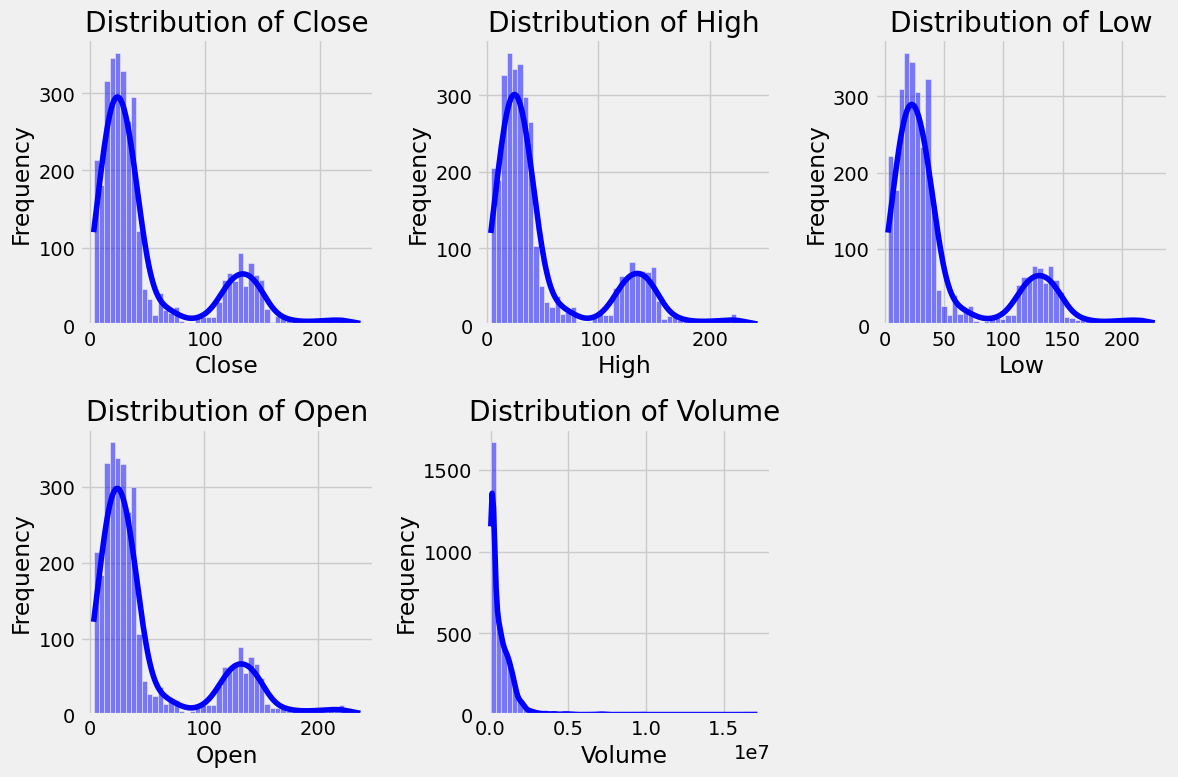

In [8]:
plt.figure(figsize=(12, 8))
feats = ['Close', 'High', 'Low', 'Open', 'Volume']

for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  sns.histplot(df[feature], kde=True, bins=50, color='blue')
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Skewness for prices and huge skew for volume

Boxplot for Outliers

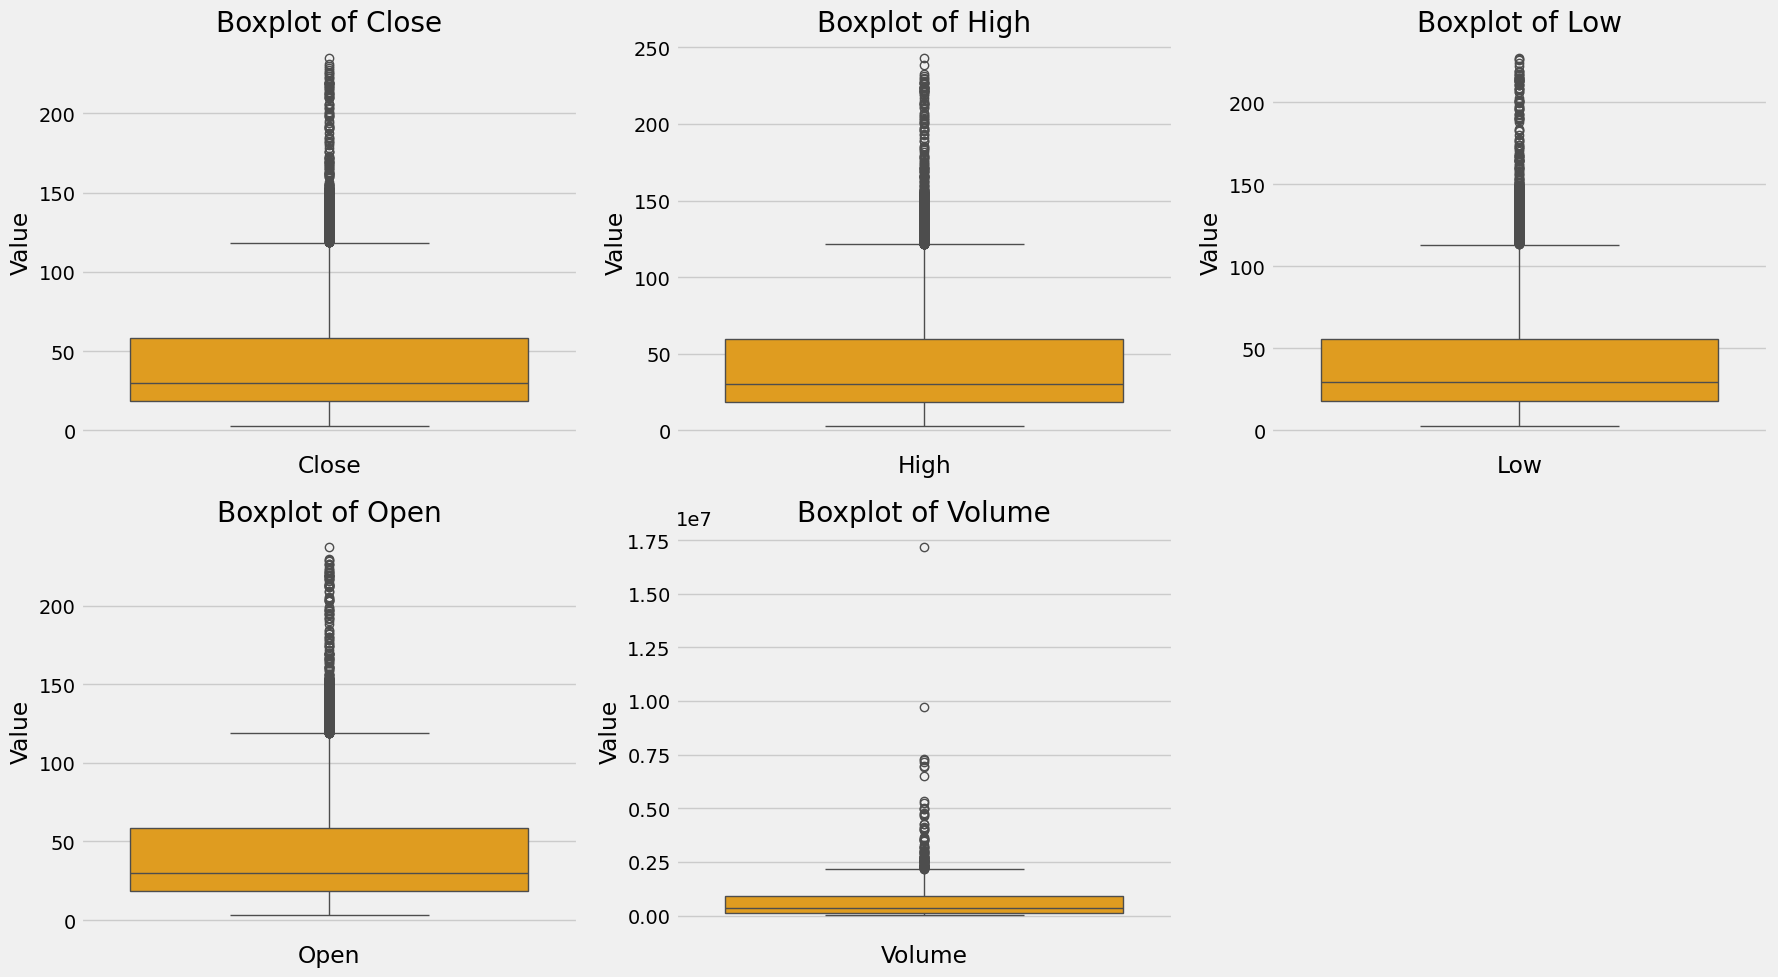

In [9]:
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  sns.boxplot(df[feature], color='orange')
  plt.title(f'Boxplot of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Value')
plt.tight_layout()
plt.show()

Rolling Window and Rolling Volatility

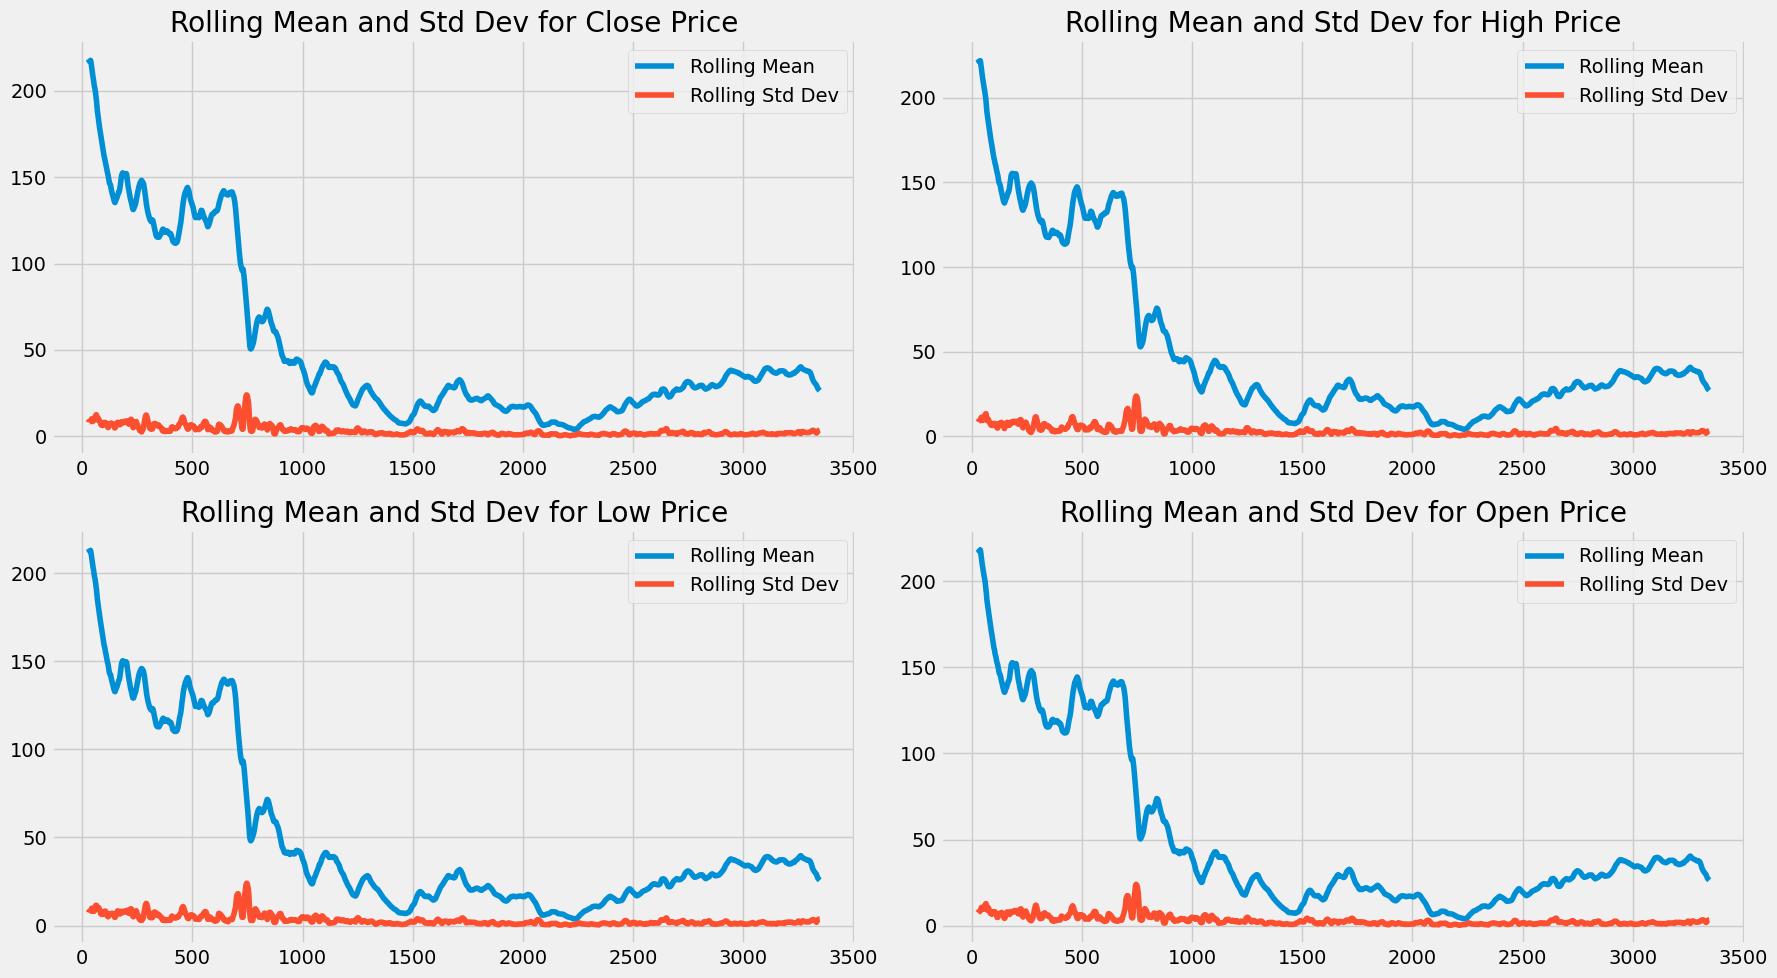

In [10]:
window_size = 30
plt.figure(figsize=(18, 10))

for idx, feature in enumerate(feats[:-1]):
  plt.subplot(2,2,idx+1)
  df[feature].rolling(window=window_size).mean().plot(label='Rolling Mean')
  df[feature].rolling(window=window_size).std().plot(label='Rolling Std Dev')
  plt.title(f'Rolling Mean and Std Dev for {feature} Price')
  # plt.xlabel('Date')
  # plt.ylabel(feature)
  plt.legend()
plt.tight_layout()
plt.show()

Rolling Mean shows trend shifts .

Rolling STD shows periods of market calm vs turbulence.




Correlation Heatmap

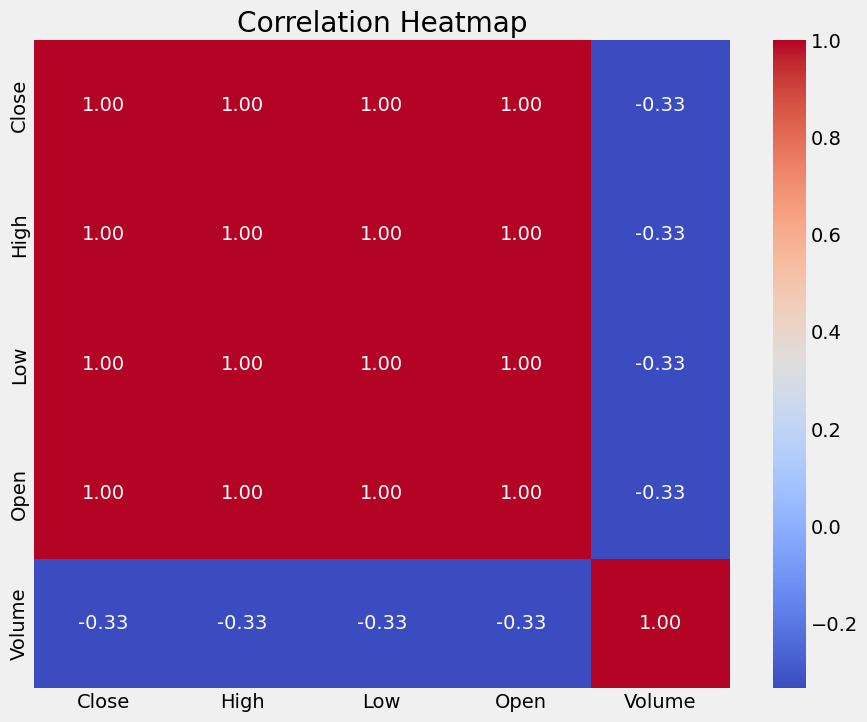

In [11]:
plt.figure(figsize=(10, 8))
corr_matrix = df[feats].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

QQ-Plots

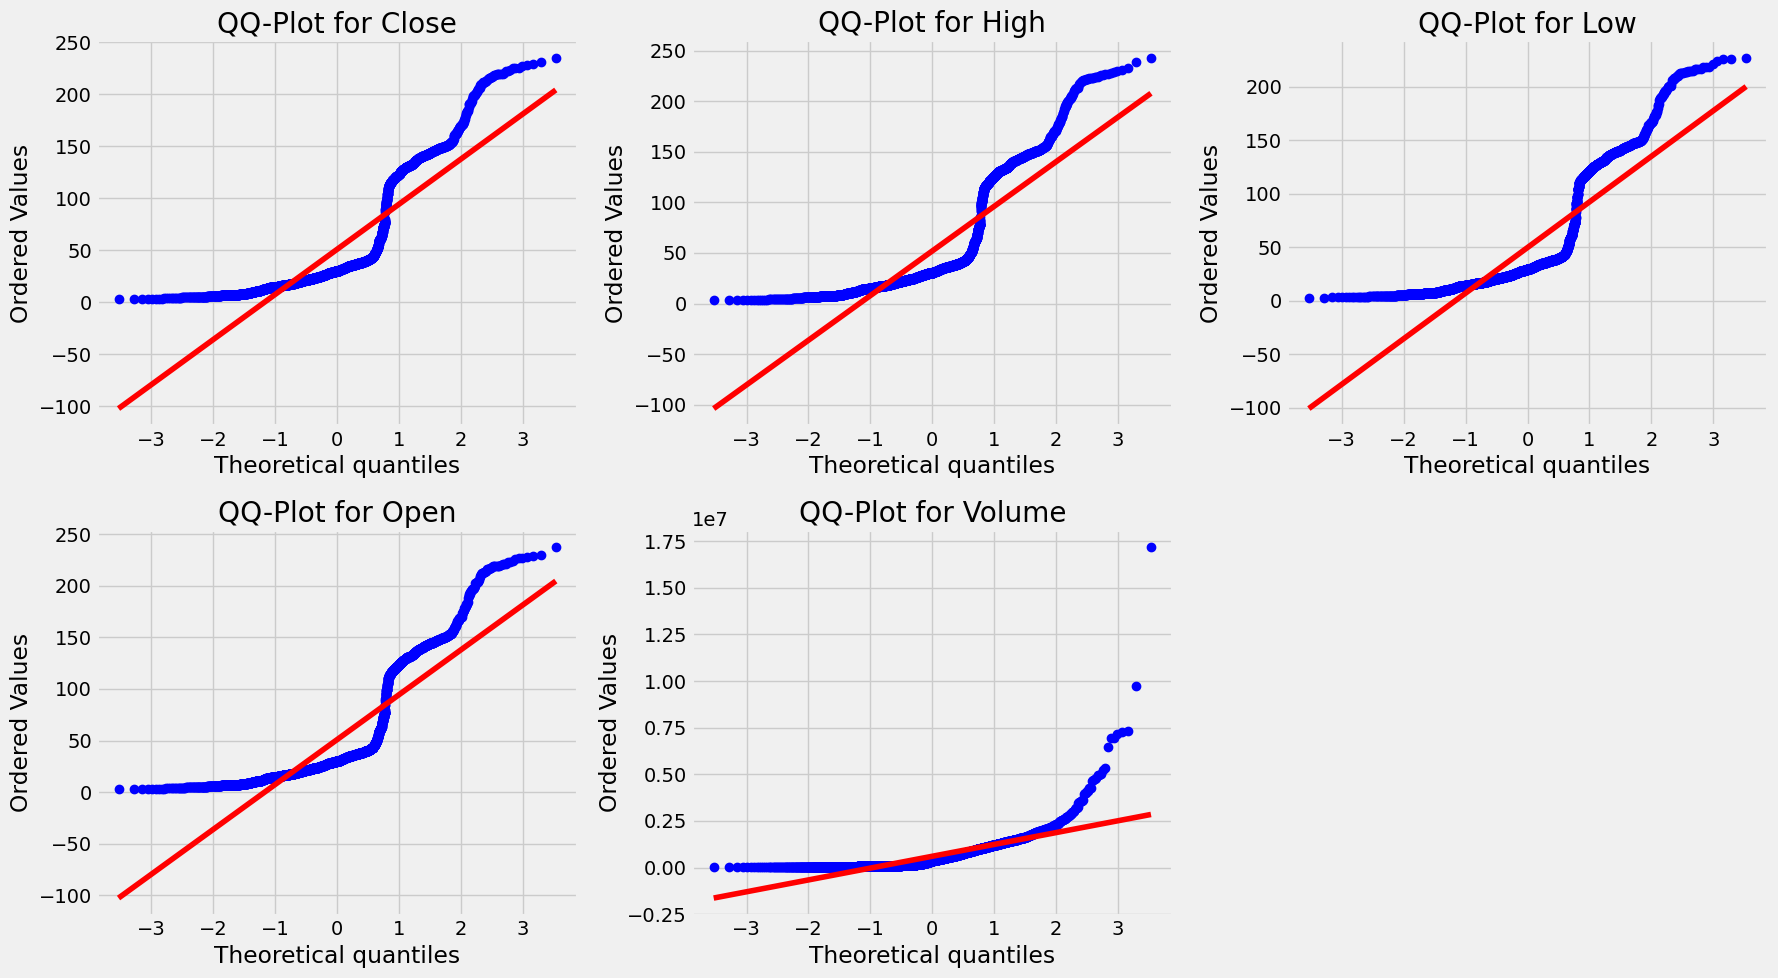

In [12]:
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  stats.probplot(df[feature], dist='norm', plot=plt)
  plt.title(f'QQ-Plot for {feature}')
plt.tight_layout()
plt.show()

The points deviate heavily from the straight line → non-normal distribution confirmed.

### The above analysis is from 2012 until today. For a more recent daily prediction we should consider a lookback window of 6 months to 2 years. Reasons for reducing the window size are:
- Markets evolve — conditions 10 years ago are not the same today (due to macro changes, technology, oil demand, Fed policies, etc.).
- Recent patterns are MUCH more relevant for short-term prediction (like predicting tomorrow).
- Old data introduces noise, reduces model's sharpness, and hurts your prediction accuracy.

## Exploratory Data Analysis - Analyze data from 2023 - 2025

In [38]:
# starttime = datetime.datetime(2023, 4, 27)
# endtime = date.today()
# ticker = "NOG"
# df = yf.download(ticker, start=starttime, end=endtime)
# df.head()

In [39]:
# headers_as_rows = pd.DataFrame([df.columns.tolist()])
# cols = [col[0] for col in headers_as_rows.iloc[0].to_list()]
# df.columns = cols
# df.reset_index(inplace=True)
# df[:2]

In [13]:
startdate = '2023-04-27'
enddate = '2025-04-30'
df = df[(df['Date'] >= startdate) & (df['Date'] <= enddate)].reset_index(drop=True)
df

,Date,Close,High,Low,Open,Volume
0,2023-04-27,29.507425,29.863596,29.023397,29.662678,787200
1,2023-04-28,30.292830,30.575941,29.279114,29.534826,742000
2,2023-05-01,30.438953,30.722062,29.626149,29.836199,1147100
3,2023-05-02,29.333906,30.155841,28.712891,30.128445,1189600
4,2023-05-03,28.311056,29.206050,28.219730,28.667227,2064100
...,...,...,...,...,...,...
496,2025-04-21,23.090000,23.850000,22.920000,23.510000,1481300
497,2025-04-22,23.559999,23.950001,23.030001,23.620001,1438400
498,2025-04-23,23.430000,24.650000,23.219999,24.270000,1410000
499,2025-04-24,23.750000,23.969999,23.500000,23.809999,1029500


In [14]:
pretty_print_eda(df, ['Close','High','Low','Open','Volume'])

,Metric Applied on,Mean,Median,Mode,Standard Deviation,Variance,Minimum,Maximum,Range,Skewness,Kurtosis,Coefficient of Variation
0,Close,3.499607e+01,3.571965e+01,0 30.210638 1 33.066757 2 33.36408...,4.083143,1.667206e+01,20.600000,4.235559e+01,2.175559e+01,-0.863012,0.660752,0.116674
1,High,3.551244e+01,3.625887e+01,0 22.700001 1 23.180000 2 23.26...,4.041822,1.633632e+01,22.700001,4.315420e+01,2.045420e+01,-0.802892,0.425591,0.113814
2,Low,3.452477e+01,3.525820e+01,0 19.879999 1 20.379999 2 21.10...,4.114605,1.692997e+01,19.879999,4.222898e+01,2.234898e+01,-0.926772,0.859461,0.119178
3,Open,3.504867e+01,3.579901e+01,"0 23.309999 Name: Open, dtype: float64",4.102282,1.682872e+01,20.170000,4.263802e+01,2.246802e+01,-0.849659,0.630111,0.117045
4,Volume,1.451391e+06,1.272300e+06,0 790400 1 828400 2 1034300 3 10...,803565.073011,6.457168e+11,396000.000000,7.156800e+06,6.760800e+06,3.324099,16.400360,0.553652


### Summary Explanation

Prices

- Sknewness - All the price columns have negative skewness. Negative skewness means the left tail is longer: Occasional sharp drops are more likely than sharp rises. Prices mostly stay stable or rise slightly, but some rare times they can crash hard.
- Kurtosis - More prone to outliers than a perfect normal distribution. Combined with negative skewness: these outliers could be sharp downward moves.
- Range - The stock has historically had big movements. Since skew is negative, the big movements are biased towards drops.
- Coefficient of Variation - ~11% pretty stable.

Volume

- Mean (1.45 million) is significantly greater than median (1.27 million) : sign of a positively skewed distribution. Hence, most days volume is normal or low, but some days are extremely high, pulling the mean up.
- Skewness - A skewness > +1.0 is considered strongly positively skewed. Few days with extremely large volumes — i.e., activity spikes. The tail is stretched to the right → higher volume days.
- Kurtosis - 16.4 is extremely high kurtosis, huge-volume days are extreme outliers.
- Range - That is an enormous spread — means some days volume exploded compared to typical days.
- Coefficient of Variance - 55% shows massive instability and spikes relative to the average volume.

Distribution Plots for visualizing our analysis

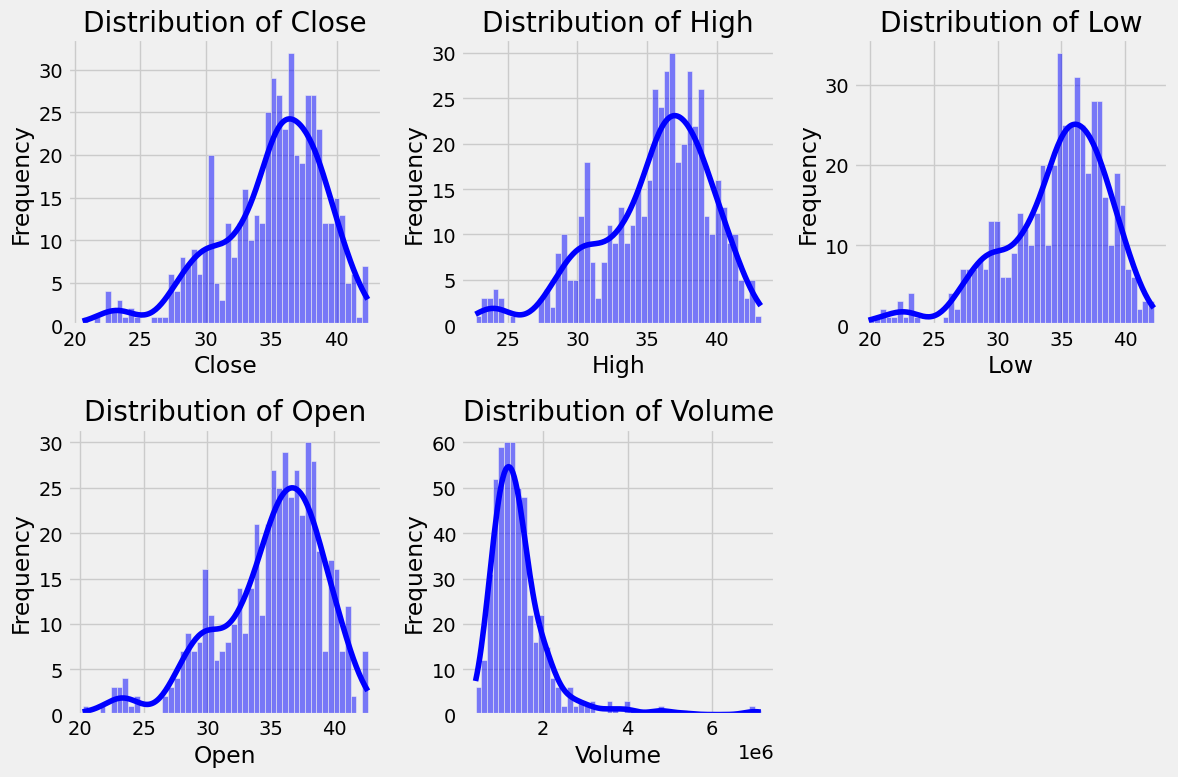

In [15]:
plt.figure(figsize=(12, 8))
feats = ['Close', 'High', 'Low', 'Open', 'Volume']

for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  sns.histplot(df[feature], kde=True, bins=50, color='blue')
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Boxplot for Outliers

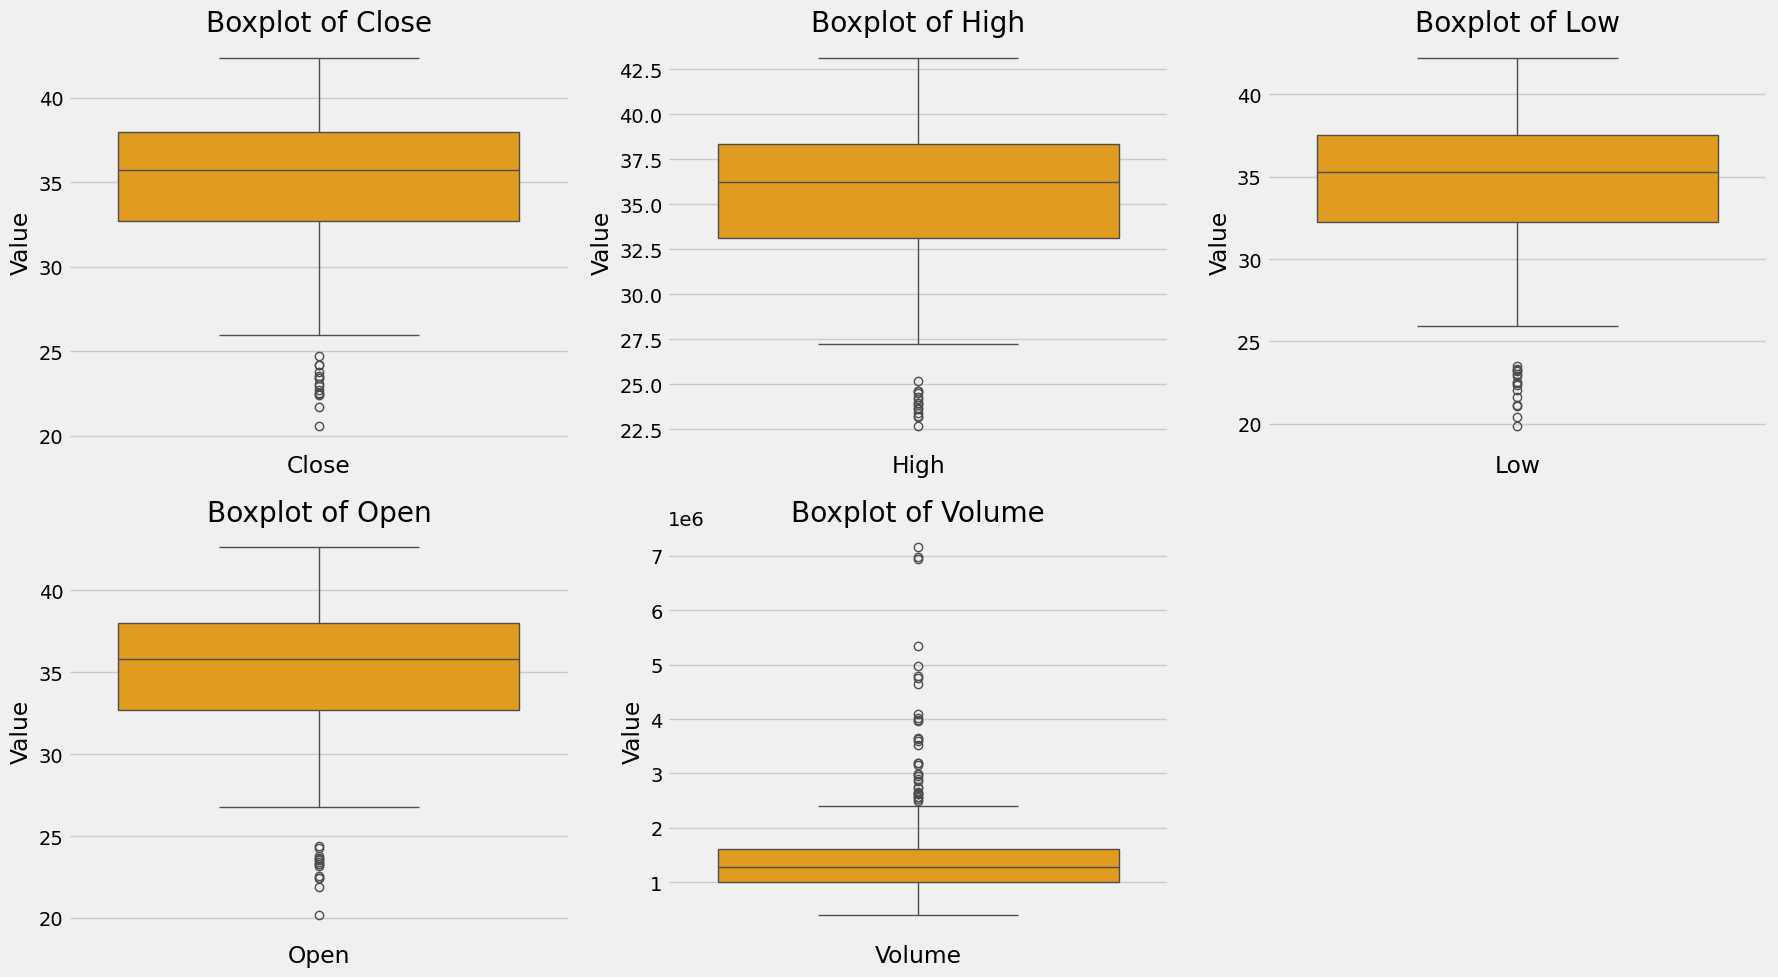

In [16]:
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  sns.boxplot(df[feature], color='orange')
  plt.title(f'Boxplot of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Value')
plt.tight_layout()
plt.show()

Rolling Window and Rolling Volatility

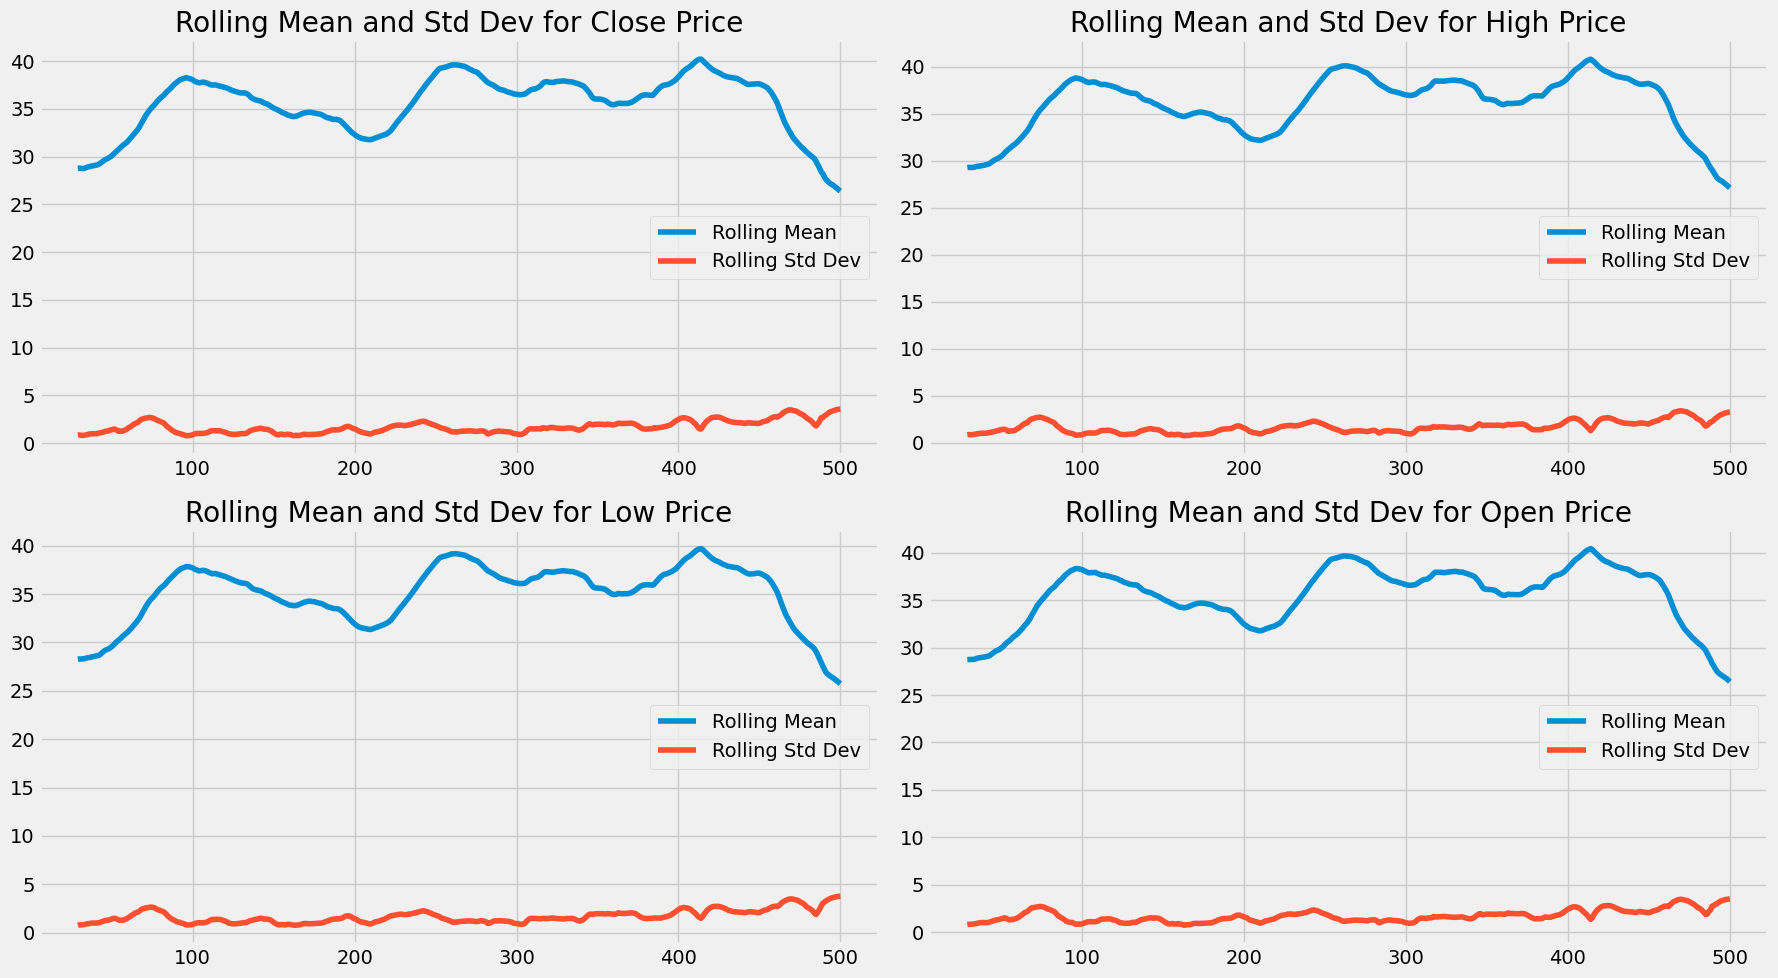

In [17]:
window_size = 30
plt.figure(figsize=(18, 10))

for idx, feature in enumerate(feats[:-1]):
  plt.subplot(2,2,idx+1)
  df[feature].rolling(window=window_size).mean().plot(label='Rolling Mean')
  df[feature].rolling(window=window_size).std().plot(label='Rolling Std Dev')
  plt.title(f'Rolling Mean and Std Dev for {feature} Price')
  # plt.xlabel('Date')
  # plt.ylabel(feature)
  plt.legend()
plt.tight_layout()
plt.show()

Correlation Heatmap

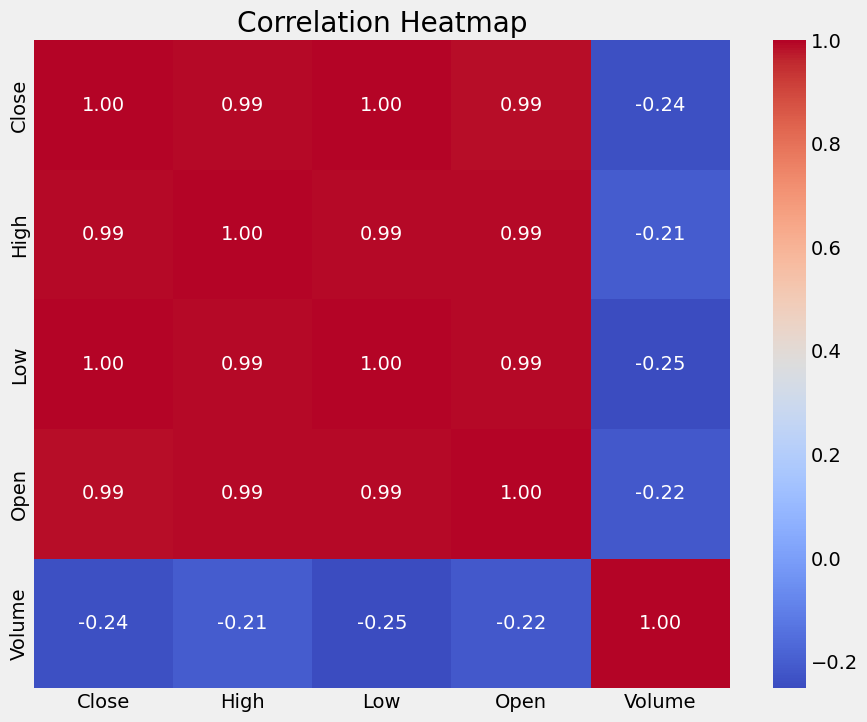

In [18]:
plt.figure(figsize=(10, 8))
corr_matrix = df[feats].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

QQ-Plots

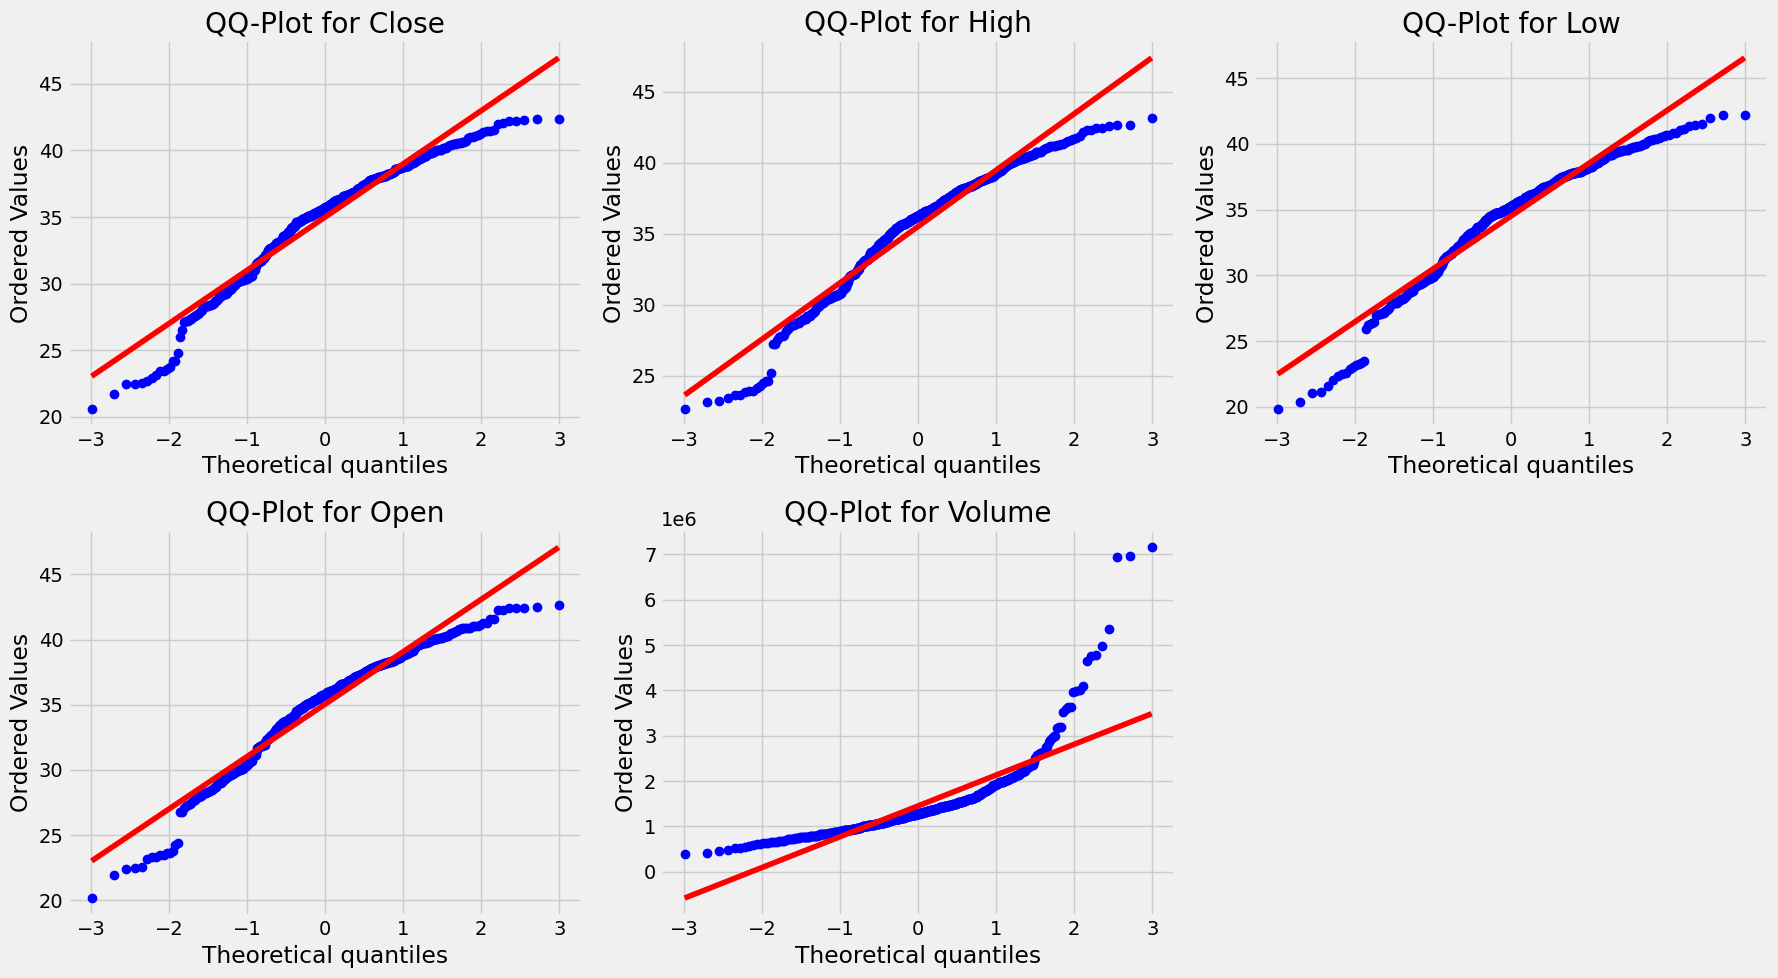

In [19]:
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  stats.probplot(df[feature], dist='norm', plot=plt)
  plt.title(f'QQ-Plot for {feature}')
plt.tight_layout()
plt.show()

### Conclusion

**Price distribution is volatile, negatively skewed, and prone to sudden large downward moves but often recovers over time. Potentially profitable for long-term, cautious investors**

**Volume distribution is highly asymmetric, fat-tailed, and shows extreme outliers.**

## Feature Engineering

Moving averages on closing price: Captures short- and long-term trends in stock prices.

To capture trends, seasonality, or other temporal patterns

In [20]:
df['ma_10'] = pd.DataFrame(df['Close'].rolling(10).mean())
# df['ma_20'] = pd.DataFrame(df['Close'].rolling(20).mean())
# df['ma_30'] = pd.DataFrame(df['Close'].rolling(30).mean())
# df['ma_40'] = pd.DataFrame(df['Close'].rolling(40).mean())
df['ma_50'] = pd.DataFrame(df['Close'].rolling(50).mean())

Plot the rolling window last 200 data points

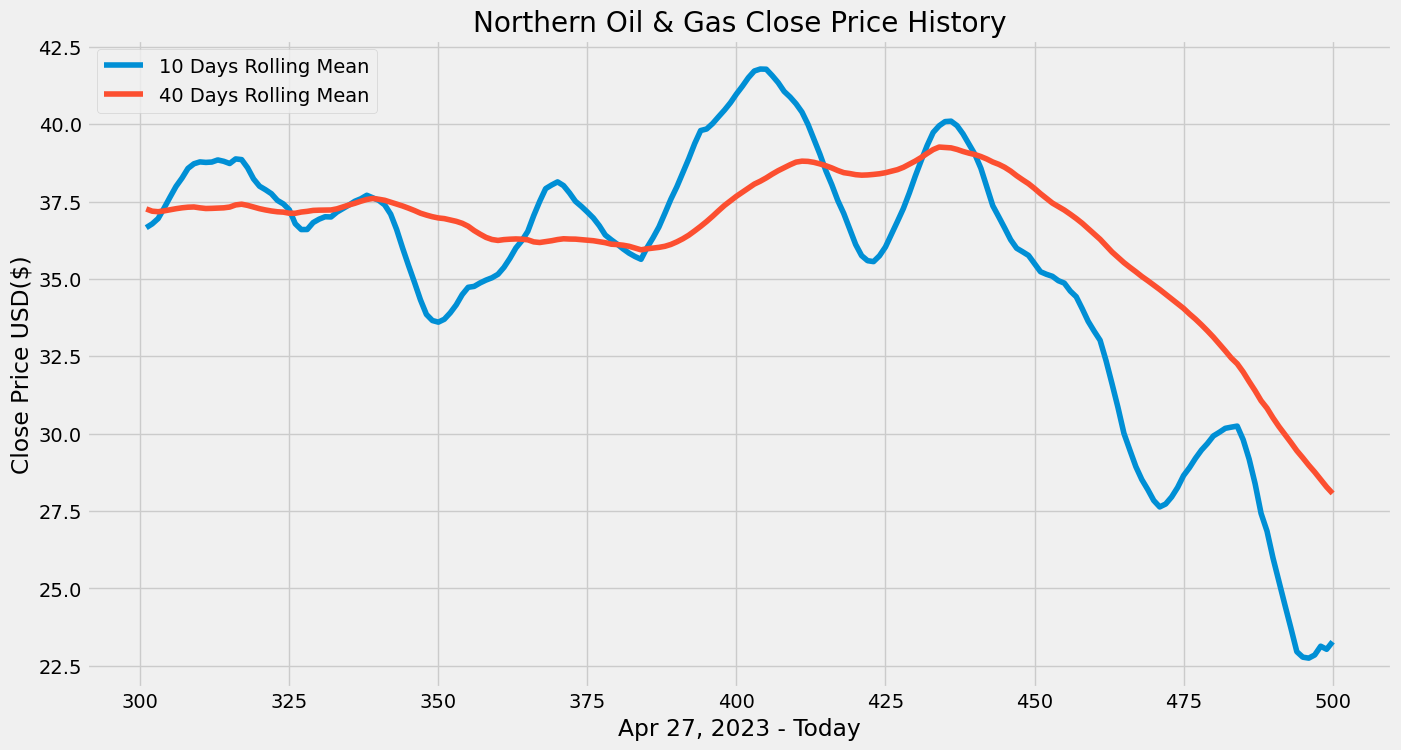

In [21]:
plt.figure(figsize=(15,8))
plt.plot(df['ma_10'].tail(200), label='10 Days Rolling Mean')
# plt.plot(df['ma_20'].tail(200), label='20 Days Rolling Mean')
# plt.plot(df['ma_30'].tail(200), label='30 Days Rolling Mean')
plt.plot(df['ma_50'].tail(200), label='40 Days Rolling Mean')
plt.title('Northern Oil & Gas Close Price History')
plt.xlabel('Apr 27, 2023 - Today')
plt.ylabel('Close Price USD($)')
plt.legend(loc='upper left')
plt.show()

Volatility (Daily Percentage Change and Rolling Standard Deviation): Measures the stock’s price fluctuation over a rolling 10, 20, 30, 40-day period

In [22]:
df['daily_change'] = df['Close'].pct_change()
df['volatility_10'] = df['daily_change'].rolling(10).std()
# df['volatility_20'] = df['daily_change'].rolling(20).std()
# df['volatility_30'] = df['daily_change'].rolling(30).std()
# df['volatility_40'] = df['daily_change'].rolling(40).std()

Relative Strength Index (RSI): Indicates overbought or oversold conditions (values over 70 imply overbought, under 30 imply oversold)

In [23]:
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

Bollinger Bands are a technical analysis tool that helps you visualize the volatility and potential overbought or oversold conditions of a stock

In [24]:
df['RSI_14'] = calculate_rsi(df['Close'], window=14)

# Calculate Bollinger Bands
bb_indicator = ta.volatility.BollingerBands(close=df['Close'], window=20)
df['bb_high'] = bb_indicator.bollinger_hband()
df['bb_low'] = bb_indicator.bollinger_lband()

Momentum: Quantifies the rate of price changes over a specified time frame (10 days in this case)

To capture trends, seasonality, or other temporal patterns

In [25]:
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)  # Price difference over 10 days
# df['Momentum_20'] = df['Close'] - df['Close'].shift(20)
# df['Momentum_30'] = df['Close'] - df['Close'].shift(30)

Volume-Weighted Average Price (VWAP) = (Cumulative Sum of (Price * Volume)) / (Cumulative Sum of Volume)

In [26]:
df['Cumulative_Price_Volume'] = (df['Close'] * df['Volume']).cumsum()
df['Cumulative_Volume'] = df['Volume'].cumsum()
df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']

In [27]:
df.tail()

,Date,Close,High,Low,Open,Volume,ma_10,ma_50,daily_change,volatility_10,RSI_14,bb_high,bb_low,Momentum_10,Cumulative_Price_Volume,Cumulative_Volume,VWAP
496,2025-04-21,23.090000,23.850000,22.920000,23.510000,1481300,22.742,28.977863,-0.045473,0.088852,34.033991,33.351709,18.566189,-0.309999,2.493683e+10,722110800,34.533243
497,2025-04-22,23.559999,23.950001,23.030001,23.620001,1438400,22.844,28.756130,0.020355,0.087909,35.959054,32.769419,18.455653,1.019999,2.497072e+10,723549200,34.511428
498,2025-04-23,23.430000,24.650000,23.219999,24.270000,1410000,23.127,28.513272,-0.005518,0.081835,33.607682,32.167945,18.380865,2.830000,2.500375e+10,724959200,34.489876
499,2025-04-24,23.750000,23.969999,23.500000,23.809999,1029500,23.028,28.274252,0.013658,0.049994,43.703706,31.423361,18.450639,-0.990000,2.502820e+10,725988700,34.474646
500,2025-04-25,24.160000,24.160000,23.309999,23.309999,1158300,23.272,28.065308,0.017263,0.027399,52.467533,30.618536,18.634464,2.440001,2.505619e+10,727147000,34.458215


# Macroeconomic Data
Fetch crude oil prices from FRE: this indicator is economy-wide and not specific to any one company's performance.

FRED’s series "DCOILWTICO" provides the daily spot price of West Texas Intermediate (WTI) crude oil. For a company like NOG, which operates in the oil and gas sector, crude oil prices are highly significant. Changes in crude oil prices can directly impact NOG’s revenues, costs, and overall stock performance.

In [28]:
starttime = pd.to_datetime(startdate)
endtime = pd.to_datetime(enddate)

In [29]:
# Download Crude Oil Prices and Federal Funds Rate from FRED using pandas_datareader
oil_prices = web.DataReader('DCOILWTICO', 'fred', starttime, endtime)
oil_prices.reset_index(inplace=True)
oil_prices.rename(columns={'DATE': 'Date', 'DCOILWTICO': 'Crude_Oil'}, inplace=True)
oil_prices['Date'] = pd.to_datetime(oil_prices['Date'])
oil_prices.sort_values('Date', inplace=True)

The series "FEDFUNDS" represents the effective federal funds rate, which is an important measure of monetary policy in the United States. The federal funds rate influences borrowing costs, which can affect everything from consumer spending to the financing costs for companies—including NOG.

In [30]:
fed_funds = web.DataReader('FEDFUNDS', 'fred', starttime, endtime)
fed_funds.reset_index(inplace=True)
fed_funds.rename(columns={'DATE': 'Date', 'FEDFUNDS': 'Fed_Funds_Rate'}, inplace=True)
fed_funds['Date'] = pd.to_datetime(fed_funds['Date'])
fed_funds.sort_values('Date', inplace=True)

Concat the two macroeconomic data

In [31]:
# Merge the two macroeconomic indicators into one DataFrame
macro_data = pd.merge_asof(oil_prices, fed_funds, on='Date', direction='backward')
macro_data.fillna(method='ffill', inplace=True)  # Forward fill any missing values

<ipython-input-31-31825c0c5527>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='ffill', inplace=True)  # Forward fill any missing values


## Merge Market Stock Data + Macroeconomic Data

In [32]:
df['Date'] = pd.to_datetime(df['Date'])

In [33]:
# Merge NOG stock data with the macroeconomic data on Date
merged_data = pd.merge_asof(df, macro_data, on='Date', direction='backward')
merged_data.fillna(method='ffill', inplace=True)

<ipython-input-33-0d5c28891512>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [34]:
merged_data.dropna(inplace=True)

In [35]:
merged_data.shape

(452, 19)

In [36]:
merged_data.tail()

,Date,Close,High,Low,Open,Volume,ma_10,ma_50,daily_change,volatility_10,RSI_14,bb_high,bb_low,Momentum_10,Cumulative_Price_Volume,Cumulative_Volume,VWAP,Crude_Oil,Fed_Funds_Rate
496,2025-04-21,23.090000,23.850000,22.920000,23.510000,1481300,22.742,28.977863,-0.045473,0.088852,34.033991,33.351709,18.566189,-0.309999,2.493683e+10,722110800,34.533243,63.48,4.33
497,2025-04-22,23.559999,23.950001,23.030001,23.620001,1438400,22.844,28.756130,0.020355,0.087909,35.959054,32.769419,18.455653,1.019999,2.497072e+10,723549200,34.511428,64.60,4.33
498,2025-04-23,23.430000,24.650000,23.219999,24.270000,1410000,23.127,28.513272,-0.005518,0.081835,33.607682,32.167945,18.380865,2.830000,2.500375e+10,724959200,34.489876,62.64,4.33
499,2025-04-24,23.750000,23.969999,23.500000,23.809999,1029500,23.028,28.274252,0.013658,0.049994,43.703706,31.423361,18.450639,-0.990000,2.502820e+10,725988700,34.474646,63.55,4.33
500,2025-04-25,24.160000,24.160000,23.309999,23.309999,1158300,23.272,28.065308,0.017263,0.027399,52.467533,30.618536,18.634464,2.440001,2.505619e+10,727147000,34.458215,63.85,4.33


Feature Columns for ML/ DL models with engineered date column as sin/cos

In [37]:
feature_cols = ['High', 'Low', 'Volume', 'ma_10', 'ma_50', 'daily_change', 'volatility_10',
                'RSI_14', 'Momentum_10', 'VWAP', 'Crude_Oil', 'Fed_Funds_Rate']

Target column

In [38]:
target = 'Close'

Divide X and y data using columns and split 80% train vs 20% test

In [39]:
X = merged_data[feature_cols]
y = merged_data[target]

In [40]:
split_index = int(len(merged_data) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [41]:
merged_data[:2]

,Date,Close,High,Low,Open,Volume,ma_10,ma_50,daily_change,volatility_10,RSI_14,bb_high,bb_low,Momentum_10,Cumulative_Price_Volume,Cumulative_Volume,VWAP,Crude_Oil,Fed_Funds_Rate
49,2023-07-10,32.317417,32.372832,31.707829,31.855608,1479000,31.306367,29.524194,0.017743,0.017569,64.188583,32.442681,28.879798,3.029175,2.376390e+09,81213700,29.260955,73.05,5.12
50,2023-07-11,32.465199,32.539086,31.984916,32.409780,1245700,31.567441,29.583350,0.004573,0.017319,65.658444,32.705149,28.850093,2.610737,2.416832e+09,82459400,29.309361,74.87,5.12


# Baseline Model

In [42]:
# set index Date
# merged_data = merged_data.set_index('Date')
# merged_data.set_index('Date', inplace=True)
# Shift 'Close' to create the Target Variable: Close_next_day
merged_data['Close_predicted'] = merged_data['Close'].shift(1).rolling(window=3).mean()
merged_data.dropna(inplace=True)
# Prepare true and predicted values
y_true = merged_data['Close']
y_pred = merged_data['Close_predicted']

In [43]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

In [44]:
print("\nBaseline Model (Predict Average Close) Evaluation Metrics")
print("="*60)
print(f"{'Mean Absolute Error (MAE)':35}: {mae:10.4f}")
print(f"{'Mean Squared Error (MSE)':35}: {mse:10.4f}")
print(f"{'Root Mean Squared Error (RMSE)':35}: {rmse:10.4f}")
print(f"{'R-squared (R² Score)':35}: {r2:10.4f}")
print("="*60)


Baseline Model (Predict Average Close) Evaluation Metrics
Mean Absolute Error (MAE)          :     0.7829
Mean Squared Error (MSE)           :     1.1658
Root Mean Squared Error (RMSE)     :     1.0797
R-squared (R² Score)               :     0.9204


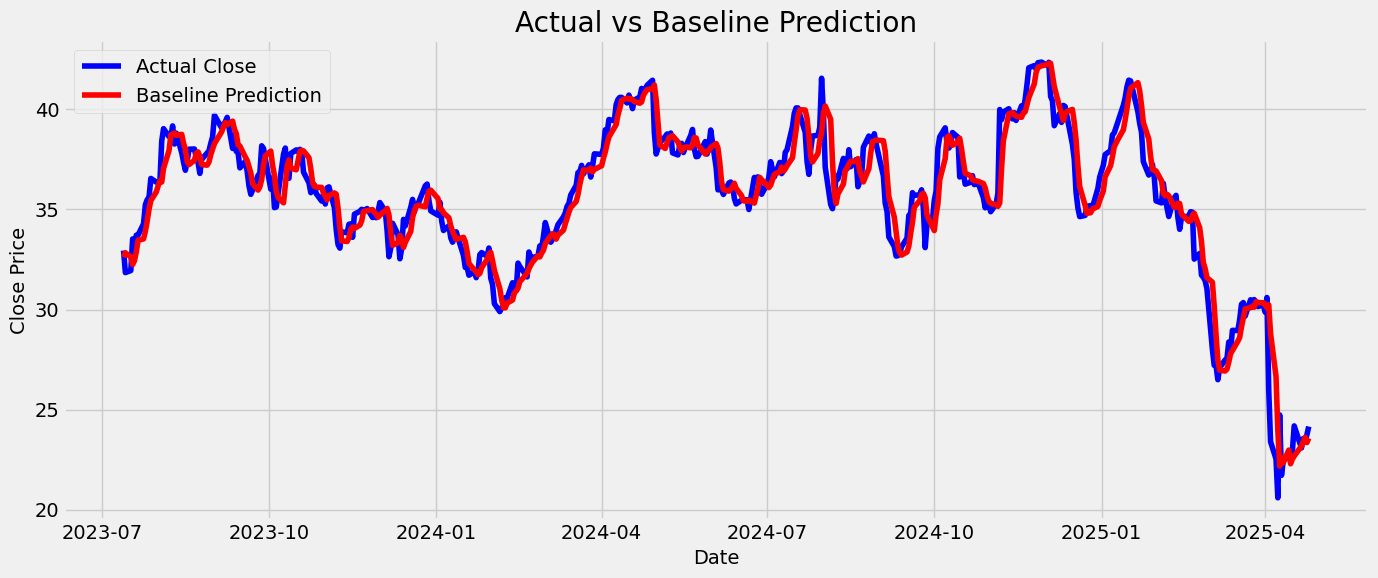

In [45]:
plt.figure(figsize=(14, 6))
plt.plot(merged_data['Date'], merged_data['Close'], label='Actual Close', color='blue')
plt.plot(merged_data['Date'], merged_data['Close_predicted'], label='Baseline Prediction', color='red')
plt.title('Actual vs Baseline Prediction')
plt.xlabel('Date',  fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Linear Regression

In [46]:
features = [
        'High', 'Low', 'Open', 'Volume', 'ma_10', 'ma_50', 'daily_change',
    'volatility_10', 'RSI_14', 'bb_high', 'bb_low', 'Momentum_10',
    'Cumulative_Price_Volume', 'Cumulative_Volume', 'VWAP', 'Crude_Oil', 'Fed_Funds_Rate'
]

In [47]:
merged_data.sort_values('Date', inplace=True)
merged_data = merged_data.dropna(subset=features + [target])

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_data[features])
y = merged_data[target].values
dates = merged_data['Date'].values  # For plotting

Train test split

In [49]:
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_scaled, y, dates, test_size=0.2, random_state=42)

Scale the data

In [50]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Predict the y for test data

In [51]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Evaluate the model

In [52]:
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

In [53]:
print("\nLinear Regression Model (Predict Average Close) Evaluation Metrics")
print("="*60)
print(f"{'Mean Absolute Error (MAE)':35}: {mae:10.4f}")
print(f"{'Mean Squared Error (MSE)':35}: {mse:10.4f}")
print(f"{'Root Mean Squared Error (RMSE)':35}: {rmse:10.4f}")
print(f"{'R-squared (R² Score)':35}: {r2:10.4f}")
print("="*60)


Linear Regression Model (Predict Average Close) Evaluation Metrics
Mean Absolute Error (MAE)          :     0.1909
Mean Squared Error (MSE)           :     0.0595
Root Mean Squared Error (RMSE)     :     0.2440
R-squared (R² Score)               :     0.9970


Plot the predicted and actual values

In [54]:
y_test_pred[:2]

array([38.68212574, 33.39662076])

In [55]:
resultdf = pd.DataFrame({'Date': pd.to_datetime(dates_test), 'Actual': y_test, 'Predicted': y_test_pred})
resultdf.sort_values('Date', inplace=True)

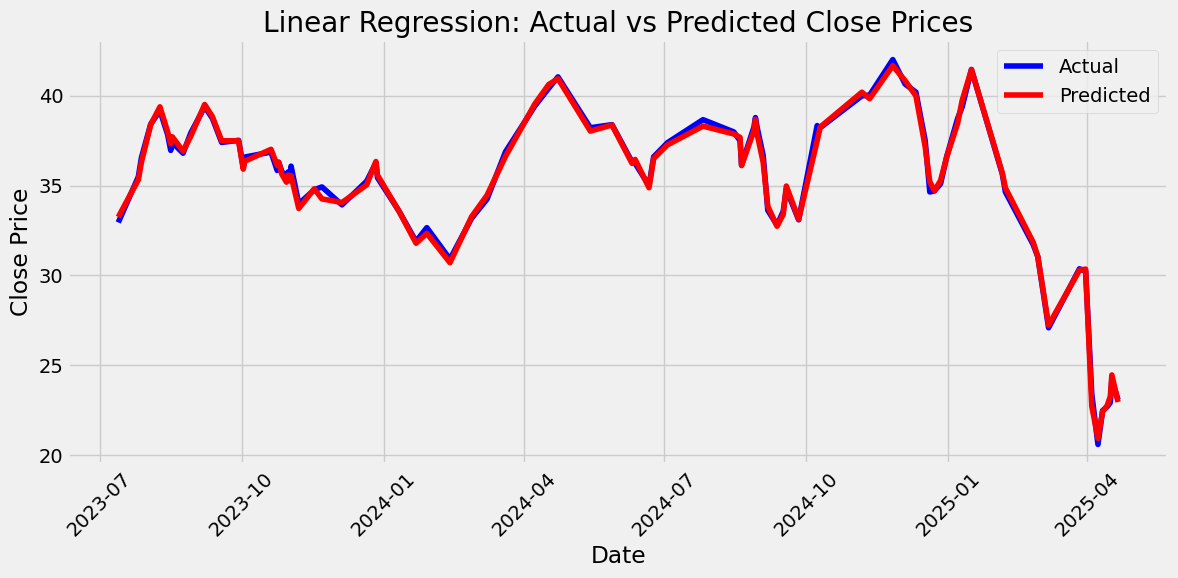

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(resultdf['Date'], resultdf['Actual'], label='Actual', color='blue')
plt.plot(resultdf['Date'], resultdf['Predicted'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression: Actual vs Predicted Close Prices')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Results looks great! But moving on to better ML models for improving generalization, robustness to outliers, to get better insights and interpretability. **

# XGBoost

In [57]:
features = merged_data.drop(columns=['Date', 'Close'])
target = merged_data['Close']

Train test split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

XGBoost model definition

In [59]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Predict using the model

In [60]:
y_pred = xgb_model.predict(X_test)

Eval metric

In [61]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [62]:
print("\nXGBoost Regression Performance")
print("="*40)
print(f"Mean Absolute Error (MAE)     : {mae:.4f}")
print(f"Mean Squared Error (MSE)      : {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R² Score)          : {r2:.4f}")


XGBoost Regression Performance
Mean Absolute Error (MAE)     : 0.2512
Mean Squared Error (MSE)      : 0.1147
Root Mean Squared Error (RMSE): 0.3387
R-squared (R² Score)          : 0.9943


In [ ]:
# results_df = pd.DataFrame({
#     'Date': merged_data['Date'].iloc[-len(y_test):].values,
#     'Actual': y_test.values,
#     'Predicted': y_pred
# })
# # Ensure the 'Date' column is in datetime format
# results_df['Date'] = pd.to_datetime(results_df['Date'])

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(results_df['Date'], results_df['Actual'], label='Actual Close Price', color='blue')
# plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted Close Price', color='red')
# plt.title('XGBoost: Actual vs Predicted Close Prices')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.xticks(rotation=45)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Feature Importance

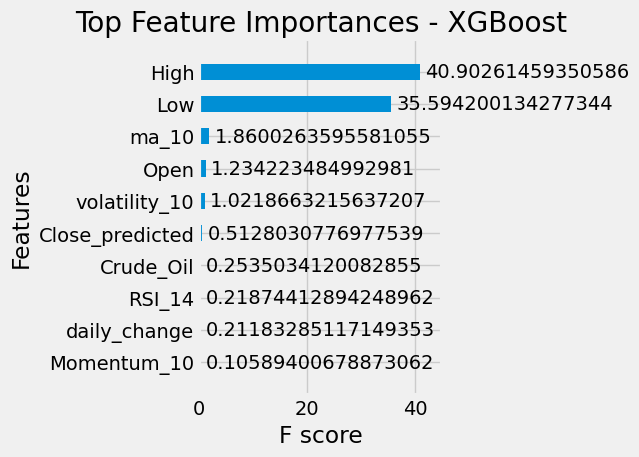

In [63]:
xgb.plot_importance(xgb_model, height=0.5, max_num_features=10, importance_type='gain')
plt.title("Top Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

Param grid - param search space

In [64]:
param_grid = {
    'learning_rate':[0.01, 0.1],
    'max_depth':[3, 5],
    'subsample':[0.7, 0.8],
    'n_estimators':[100, 200]
}

Hyperparameter tuning

In [65]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [66]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.7, 0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [67]:
# Retrieve the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


In [68]:
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.2263
Root Mean Squared Error (RMSE): 0.3108
R-squared (R²): 0.9952


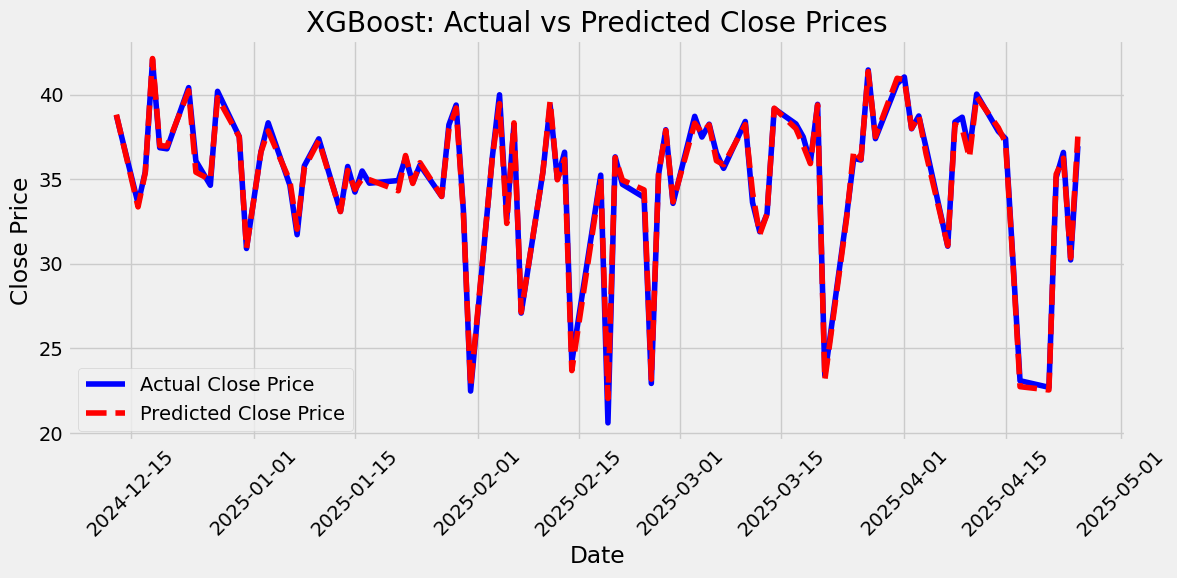

In [69]:
results_df = pd.DataFrame({
    'Date': df['Date'].iloc[-len(y_test):].values,
    'Actual': y_test.values,
    'Predicted': y_pred
})

results_df['Date'] = pd.to_datetime(results_df['Date'])
results_df.sort_values('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual Close Price', color='blue')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted Close Price', color='red', linestyle='--')
plt.title('XGBoost: Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Retrieve best params

# SARIMA

Feature Engineering for the time series models

In [70]:
timeseriesfeatures = ['High', 'Low', 'Open', 'Volume', 'ma_10', 'ma_50',
             'daily_change', 'volatility_10', 'RSI_14', 'Momentum_10', 'VWAP', 'Crude_Oil', 'Fed_Funds_Rate']
exog_vars = merged_data.set_index('Date')[timeseriesfeatures]
targetseries = merged_data.set_index('Date')['Close']

Split the data test and train data 80% and 20%

In [71]:
split_idx = int(len(merged_data) * 0.8)
train_features = exog_vars[:split_idx]
test_features = exog_vars[split_idx:]
train_target = targetseries[:split_idx]
test_target = targetseries[split_idx:]

 order=(p,d,q)

 p	AR (autoregressive) — how many past values to use

 d	I (integrated) — how many times to difference the series to make it stationary

 q	MA (moving average) — how many past forecast errors to use

In [72]:
model_arima = SARIMAX(train_target, exog=train_features, order=(5, 1, 0))
result_arima = model_arima.fit(disp=False)
print(result_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  359
Model:               SARIMAX(5, 1, 0)   Log Likelihood                  25.485
Date:                Sun, 18 May 2025   AIC                            -12.970
Time:                        17:11:23   BIC                             60.760
Sample:                             0   HQIC                            16.352
                                - 359                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
High               0.3311      0.033      9.974      0.000       0.266       0.396
Low                0.3138      0.035      8.853      0.000       0.244       0.383
Open              -0.0808      0.028

Summary of the stats

1.    Ljung-Box (L1) (Q) - Whether there's remaining autocorrelation in the residuals (i.e., if your model missed any time patterns) == 0.03

      
      High p-value (> 0.05): No significant autocorrelation left — your model is likely capturing the structure well.
2.   Jarque-Bera (JB) - Whether residuals are normally distributed (a common model assumption) == 1407.88

      
      Low p-value (< 0.05): — residuals are not normally distributed.

3. Heteroskedasticity (H) - Constant variance of residuals (a.k.a. homoskedasticity) == 0.09

      
      Low p-value (< 0.05) — there's heteroskedasticity (variance changes over time).

4. Slight left-skew — not severe. Skew near 0 is ideal
5. High kurtosis (>3) -  Residuals are leptokurtic (heavy tails).

In [74]:
forecast_arima = result_arima.predict(start=split_idx, end=len(targetseries)-1, exog=test_features)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [75]:
# Calculate evaluation metrics
mae = mean_absolute_error(test_target, forecast_arima)
rmse = np.sqrt(mean_squared_error(test_target, forecast_arima))
r2 = r2_score(test_target, forecast_arima)

# Display the metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 1.6086
Root Mean Squared Error (RMSE): 1.6966
R-squared (R²): 0.9076


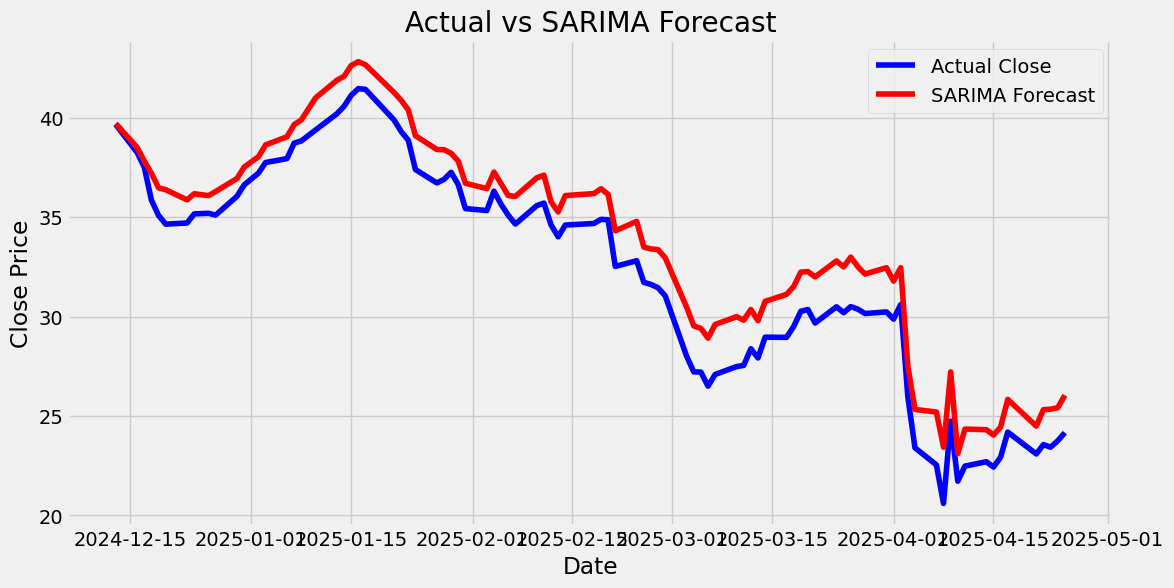

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(test_target.index, test_target, label='Actual Close', color='blue')
plt.plot(test_target.index, forecast_arima, label='SARIMA Forecast', color='red')
plt.title('Actual vs SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [77]:
import itertools
import warnings
from joblib import Parallel, delayed

def evaluate_model(order, seasonal_order, y):
    try:
        model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        return (order, seasonal_order, results.aic)
    except:
        return (order, seasonal_order, None)

In [78]:
# Define parameter grids
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [ ]:
# Create list of all parameter combinations
params = [(order, seasonal_order) for order in pdq for seasonal_order in seasonal_pdq]

# Parallel evaluation
results = Parallel(n_jobs=-1)(delayed(evaluate_model)(order, seasonal_order, y) for order, seasonal_order in params)

# Filter out failed models
results = [res for res in results if res[2] is not None]

# Find the best model
best_model = min(results, key=lambda x: x[2])
print(f'Best SARIMAX model: ARIMA{best_model[0]} x {best_model[1]}12 - AIC:{best_model[2]}')

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(test_target, forecast_arima)
rmse = np.sqrt(mean_squared_error(test_target, forecast_arima))
r2 = r2_score(test_target, forecast_arima)

# Display the metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Prophet

Download Oil Data - external regressors

WTI Crude (CL=F) — This is the benchmark oil price in the U.S

In [108]:
oil = yf.download('CL=F', start=starttime, end=endtime)
oil.reset_index(inplace=True)
newmerged = merged_data.copy()
newmerged.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [109]:
headers_as_rows = pd.DataFrame([oil.columns.tolist()])
cols = [col[0] for col in headers_as_rows.iloc[0].to_list()]
oil.columns = cols
oil.reset_index(inplace=True)

In [110]:
oil = oil[['Date','Close','High','Low','Open','Volume']]
oil.head()

,Date,Close,High,Low,Open,Volume
0,2023-04-27,74.760002,75.279999,74.029999,74.379997,345880
1,2023-04-28,76.779999,76.919998,73.930000,74.910004,328399
2,2023-05-01,75.660004,76.690002,74.529999,76.660004,215017
3,2023-05-02,71.660004,76.110001,71.419998,75.760002,417820
4,2023-05-03,68.599998,71.790001,67.949997,71.559998,490523


In [111]:
newmerged = pd.merge(merged_data, oil[['Date', 'Close']], on='Date', how='left')
newmerged.head()

,Date,Close_x,High,Low,Open,Volume,ma_10,ma_50,daily_change,volatility_10,...,bb_high,bb_low,Momentum_10,Cumulative_Price_Volume,Cumulative_Volume,VWAP,Crude_Oil,Fed_Funds_Rate,Close_predicted,Close_y
0,2023-07-13,32.945477,33.739789,32.714572,33.213327,1354400,32.062500,29.689304,-0.004188,0.016913,...,33.318018,28.872933,1.995018,2.502392e+09,85051200,29.422181,76.86,5.12,32.622213,76.889999
1,2023-07-14,31.846373,32.880825,31.790954,32.714573,1076600,32.097598,29.739553,-0.033361,0.020466,...,33.366738,29.019751,0.350975,2.536678e+09,86127800,29.452484,75.44,5.12,32.831566,75.419998
2,2023-07-17,31.947969,32.086514,31.421507,31.680119,1004300,32.122535,29.812292,0.003190,0.020401,...,33.434769,29.109928,0.249374,2.568763e+09,87132100,29.481247,74.17,5.12,32.625291,74.150002
3,2023-07-18,33.527355,33.564301,31.883315,31.883315,1498100,32.302640,29.917896,0.049436,0.025514,...,33.762191,29.094087,1.801052,2.618990e+09,88630200,29.549638,75.76,5.12,32.246606,75.750000
4,2023-07-19,33.148674,33.758262,32.806936,33.536596,854400,32.405162,29.999488,-0.011295,0.025928,...,33.961013,29.176282,1.025219,2.647313e+09,89484600,29.584001,75.40,5.12,32.440566,75.349998


In [112]:
newmerged.rename(columns={'Close_x': 'NOG_Close', 'Close_y': 'Oil_Close'}, inplace=True)
df_prophet = newmerged[['Date', 'NOG_Close', 'Crude_Oil', 'Fed_Funds_Rate', 'Volume', 'Oil_Close']].dropna()
df_prophet.rename(columns={'Date': 'ds', 'NOG_Close': 'y'}, inplace=True)

Correlation

In [113]:
newmerged[['NOG_Close', 'Oil_Close']].corr()

,NOG_Close,Oil_Close
NOG_Close,1.000000,0.529032
Oil_Close,0.529032,1.000000


52.90 % correlation between the NOG stock close price and the oil close price benchmark

In [134]:
prophet = Prophet(seasonality_mode='multiplicative',changepoint_range=1.0)
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.add_regressor('Oil_Close')
prophet_result = prophet.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphg7wbr4o/vc3vr_kf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphg7wbr4o/iwn2hwg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74114', 'data', 'file=/tmp/tmphg7wbr4o/vc3vr_kf.json', 'init=/tmp/tmphg7wbr4o/iwn2hwg3.json', 'output', 'file=/tmp/tmphg7wbr4o/prophet_modelx10bhr5x/prophet_model-20250518161516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [135]:
future = prophet.make_future_dataframe(periods=30)
future['Oil_Close'] = df_prophet['Oil_Close'].iloc[-1]
forecast = prophet.predict(future)

In [136]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
474,2025-05-21,20.167332,18.230947,22.049611
475,2025-05-22,20.012483,18.176228,22.123584
476,2025-05-23,20.045002,18.191452,22.086251
477,2025-05-24,-46.932581,-50.274704,-43.804412
478,2025-05-25,-46.686932,-50.731283,-43.437115


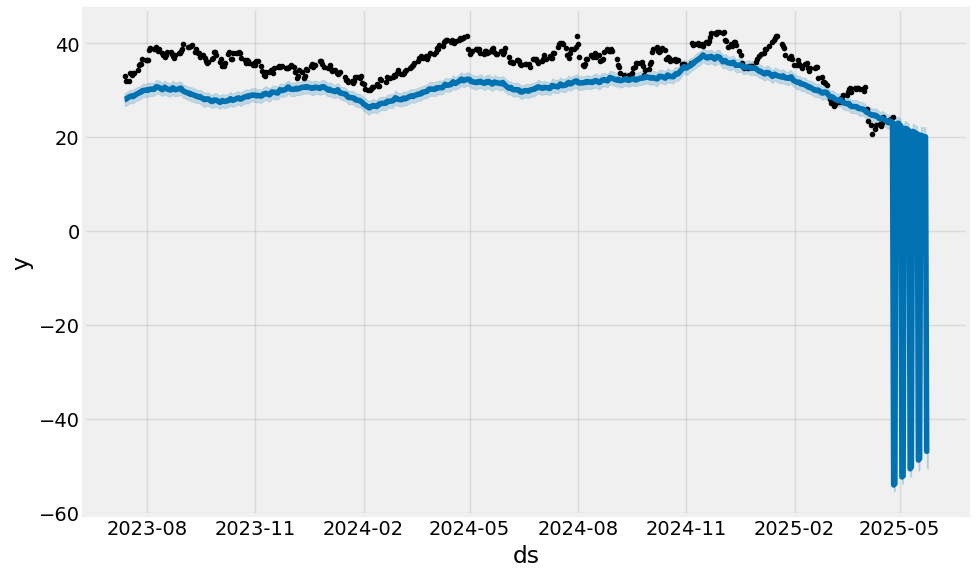

In [137]:
prophet.plot(forecast);

In [138]:
output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
output['actual'] = df_prophet[['y']].reindex(output['ds'])

<ipython-input-138-9cbb46f4ee50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['actual'] = df_prophet[['y']].reindex(output['ds'])


In [139]:
df_prophet[['y', 'ds']]

,y,ds
0,32.945477,2023-07-13
1,31.846373,2023-07-14
2,31.947969,2023-07-17
3,33.527355,2023-07-18
4,33.148674,2023-07-19
...,...,...
444,23.090000,2025-04-21
445,23.559999,2025-04-22
446,23.430000,2025-04-23
447,23.750000,2025-04-24


In [140]:
output.rename(columns={'y': 'Actual', 'yhat': 'Predicted'}, inplace=True)

<ipython-input-140-e5b8ed034672>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output.rename(columns={'y': 'Actual', 'yhat': 'Predicted'}, inplace=True)


In [141]:
output.head()

,ds,Predicted,yhat_lower,yhat_upper,actual
0,2023-07-13,27.996695,26.552954,29.417745,NaN
1,2023-07-14,28.027136,26.669364,29.375417,NaN
2,2023-07-17,28.551173,27.041312,30.025557,NaN
3,2023-07-18,28.652466,27.187367,29.998421,NaN
4,2023-07-19,28.731258,27.292451,30.129943,NaN


In [142]:
results_df = pd.merge(df_prophet, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

In [144]:
# Drop rows with NaN values in 'yhat'
results_df_clean = results_df.dropna(subset=['yhat'])

# Extract actual and predicted values
y_true = results_df_clean['y']
y_pred = results_df_clean['yhat']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Display metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R² Score): {r2:.4f}")

Mean Absolute Error (MAE): 5.2317
Mean Squared Error (MSE): 33.5433
Root Mean Squared Error (RMSE): 5.7917
R-squared (R² Score): -1.2898


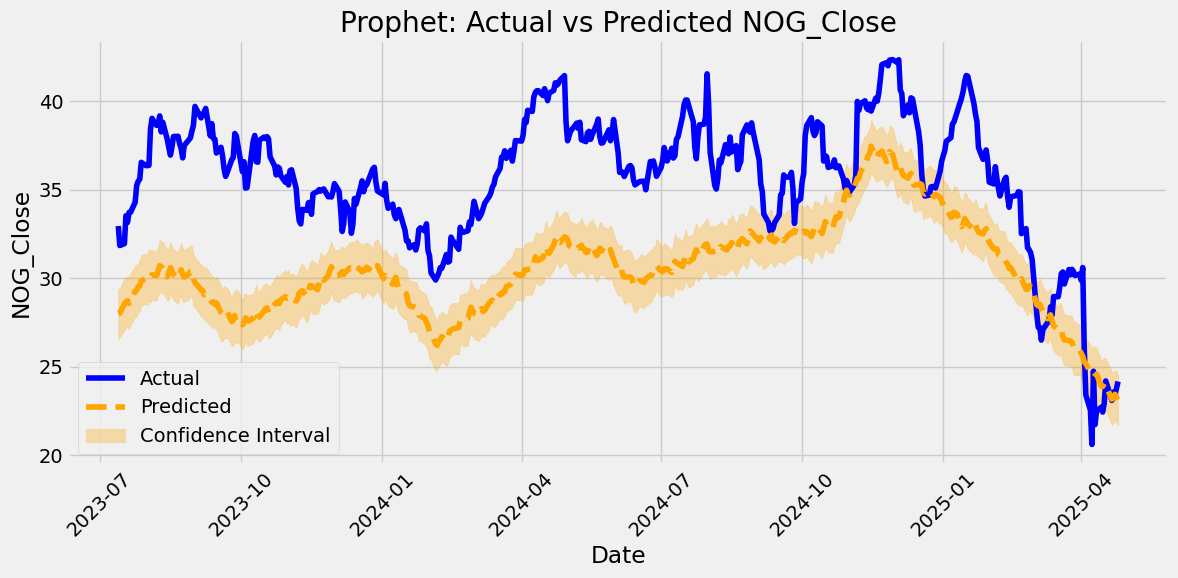

In [143]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['ds'], results_df['y'], label='Actual', color='blue')
plt.plot(results_df['ds'], results_df['yhat'], label='Predicted', color='orange', linestyle='--')
plt.fill_between(results_df['ds'], results_df['yhat_lower'], results_df['yhat_upper'], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('Prophet: Actual vs Predicted NOG_Close')
plt.xlabel('Date')
plt.ylabel('NOG_Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Analysis based on Evaluation Metric

| Model   | MAE    | RMSE   | R²      |                                                                     |
| ------- | ------ | ------ | ------- | ------------------------------------------------------------------- |
| XGBoost | 0.2263 | 0.3108 | 0.9952  |                                                                     |
| SARIMAX | 1.6086 | 1.6966 | 0.9076  |                                                                     |
| Prophet | 5.2317 | 5.7917 | -1.2898 |                                                                     |

* XGBoost demonstrates superior performance across all metrics, suggesting it effectively captures the underlying patterns in your data.

* SARIMAX performs reasonably well, especially considering its ability to model seasonality and incorporate exogenous variables.

* Prophet shows poor performance, indicated by a negative R², which suggests it fails to capture the data's structure effectively.

# Multivariate LSTM

In [ ]:
# features = ['Close','High','Low','Open','Volume','ma_10','ma_50',
#             'daily_change','volatility_10','RSI_14','Momentum_10','VWAP','Crude_Oil','Fed_Funds_Rate']
# data_lstm = merged_data[features + ['Date']].copy()
# data_lstm.set_index('Date', inplace=True)

In [ ]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data_lstm)

In [ ]:
# def create_dataset(dataset, lookback=60):
#   X, y = [], []
#   for i in range(lookback, len(dataset)):
#     X.append(dataset[i-lookback:i])
#     y.append(dataset[i, 0])
#   return np.array(X), np.array(y)

In [ ]:
# lookback = 60
# X, y = create_dataset(scaled_data, lookback)

In [ ]:
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# lstm_model.add(LSTM(units=50))
# lstm_model.add(Dense(units=1))
# lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

In [ ]:
# Inverse transform the predictions.
# # Since we scaled all features, we need to reconstruct an array where only the first column differs.
# predicted_lstm = lstm_model.predict(X_test)
# dummy = np.zeros((predicted_lstm.shape[0], len(features)))
# predicted_full = np.concatenate((predicted_lstm, dummy), axis=1)
# y_test_extended = np.concatenate((y_test.reshape(-1, 1), dummy), axis=1)

In [ ]:
# predicted_prices = scaler.inverse_transform(predicted_full)[:, 0]
# actual_prices = scaler.inverse_transform(y_test_extended)[:,0]
# plt.figure(figsize=(12,6))
# plt.plot(actual_prices, label="Actual Close", color='blue')
# plt.plot(predicted_prices, label="LSTM Predicted Close", color='red')
# plt.title("Multivariate LSTM Forecast for NOG Close Price")
# plt.xlabel("Time Steps")
# plt.ylabel("Close Price")
# plt.legend()
# plt.show()

In [ ]:
# import gspread
# from oauth2client.service_account import ServiceAccountCredentials
# from gspread_dataframe import set_with_dataframe
# import pandas as pd

In [ ]:
# # creds
# scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
# creds = ServiceAccountCredentials.from_json_keyfile_name("your_credentials.json", scope)
# client = gspread.authorize(creds)